In [1]:
import astropy.io
from astropy.io import fits
from astropy.table import vstack, Table
import dust_extinction
from astropy.modeling.models import BlackBody
import astropy.units as u
from dust_extinction.parameter_averages import F19
#import astroquery
import numpy as np
from numpy.polynomial.polynomial import polyfit
from numpy.polynomial.polynomial import Polynomial as Poly
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import StringIO 
import csv
import scipy.stats as stats
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#import sys
#locate_python = sys.exec_prefix
#print(locate_python)

# Data Files

In [4]:
# Data files

## SDSS
#SSDS galaxy data from: https://www.sdss3.org/dr8/spectro/galspec.php

# windows file path format: pd.read_csv(r"C:\Users\pheretz\Desktop\URSI_Internship\Sources Info Sheet - Catalog (8.26).csv")

#import fits data:
galSpecInfo = fits.open(r"C:\Users\pheretz\CfA Metallicity\galSpecInfo-dr8.fits",memmap=True)
#galSpecInfo
Infocols = galSpecInfo[1].columns
Infocols.names
print(Infocols.names)
SpecInfodata = galSpecInfo[1].data
#SpecInfodata = pd.DataFrame(SpecInfodata)
#print(SpecInfodata)

galSpecLine = fits.open(r"C:\Users\pheretz\CfA Metallicity\galSpecLine-dr8.fits",memmap=True)
Linecols = galSpecLine[1].columns
Linecols.names
#print(Linecols.names)
SDSSSpecLinedata = galSpecLine[1].data
OIII4363SDSS = SDSSSpecLinedata['OIII_4363_FLUX']
OIII4363errSDSS = SDSSSpecLinedata['OIII_4363_FLUX_ERR']
## 602,494 galaxies with detections
OIII4363SDSSdetect = np.where(OIII4363SDSS >0)[0]
## 33,202 galaxies with s/n greater than 3
OIII4363SDSStruedetect = np.where(OIII4363SDSS/OIII4363errSDSS >3)[0]
#print(len(OIII4363SDSS))
#print(len(OIII4363SDSStruedetect))

galSpecExtra = fits.open(r"C:\Users\pheretz\CfA Metallicity\galSpecExtra-dr8.fits",memmap=True)
Linecols2 = galSpecExtra[1].columns
Linecols2.names
#print(Linecols2.names)
SDSSSpecExtradata = galSpecExtra[1].data
#SDSSSpecExtradata = pd.DataFrame(SDSSSpecExtradata)


## BATTISTI SDSS DATA
# source paper: https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.4431B/abstract

#import dat files:
BattistiSpecLine = np.genfromtxt('SDSS_DR7_sfg_lines.dat', names=True)
BattistiSpecProp = np.genfromtxt('SDSS_DR7_sfg_prop.dat', names=True)
#see column names:
print(BattistiSpecProp.dtype.names)
#print(BattistiSpecProp[5])
print(BattistiSpecLine.dtype.names)
# Stellar mass
w = np.where(BattistiSpecProp['logM_p50']>0)[0]  
#print(min(BattistiSpecProp['logM_p50'][w]))
#print(max(BattistiSpecProp['logM_p50'][w]))
print(sum(BattistiSpecProp['logM_p50'][w])/len(BattistiSpecProp['logM_p50'][w]))
# SFR
w = np.where(BattistiSpecProp['logSFR_p50']>0)[0]  
#print(min(BattistiSpecProp['logSFR_p50'][w]))
#print(max(BattistiSpecProp['logSFR_p50'][w]))
print(sum(BattistiSpecProp['logSFR_p50'][w])/len(BattistiSpecProp['logSFR_p50'][w]))

## MAPPINGS
BPASS = np.genfromtxt('grid_bpass_P6.csv',names=True,delimiter=",", dtype=str)
#display(BPASS)
#BPASScols = BPASS.columns
#print(BPASS.dtype.names)

## MOSDEF!!
# corrected data, balmer lines are corrected for stellar absorption
MOSDEFlines = fits.open('linemeas_cor.fits',memmap=True)
MOSDEFLinecols = MOSDEFlines[1].columns
#print(MOSDEFLinecols.names)
MOSDEFdata = MOSDEFlines[1].data
MOSDEFdata = pd.DataFrame(MOSDEFdata)

## MOSDEF Lines 
# recommend using the preferred flux, ** already corrected for s/n > 3**
# OIII doublet
OIII5008_MOSDEF = MOSDEFdata['OIII5008_PREFERREDFLUX']
OIII4960_MOSDEF = MOSDEFdata['OIII4960_PREFERREDFLUX']
### THIS IS THE AURORAL LINE!!! :D
OIII4364_MOSDEF = MOSDEFdata['OIII4364_PREFERREDFLUX']
OIII4364detect = np.where(OIII4364_MOSDEF >0)[0]
#print(len(OIII4364detect))
Ha_MOSDEF = MOSDEFdata['HA6565_PREFERREDFLUX']
Hb_MOSDEF = MOSDEFdata['HB4863_PREFERREDFLUX']
NII85_MOSDEF = MOSDEFdata['NII6585_PREFERREDFLUX']
NII50_MOSDEF = MOSDEFdata['NII6550_PREFERREDFLUX']

#MOSDEFdata = MOSDEFdata.loc[(OIII5008_MOSDEF>0)& (OIII4960_MOSDEF>0) &( Ha_MOSDEF >0)&(Hb_MOSDEF>0)&(NII85_MOSDEF>0)&(NII50_MOSDEF>0)]

# try to segment star-forming
#MOSDEFstarform = np.where( (OIII5008_MOSDEF>0)& (OIII4960_MOSDEF>0) &( Ha_MOSDEF >0)&(Hb_MOSDEF>0)&(NII85_MOSDEF>0)&(NII50_MOSDEF>0))
#MOSDEFstarform = MOSDEFdata.loc[(np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))>((0.61/(np.log10((NII85_MOSDEF/Ha_MOSDEF))-0.05))+1.3))]#&((NII85_MOSDEF/Ha_MOSDEF)>0)]
MOSDEFstarform = MOSDEFdata.mask(np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))>((0.61/(np.log10((NII85_MOSDEF/Ha_MOSDEF))-0.05))+1.3))
MOSDEFstarform = MOSDEFstarform.mask(np.log10((NII85_MOSDEF/Ha_MOSDEF))>0)
MOSDEFstarform_top = MOSDEFstarform.head(0)

#print(MOSDEFstarform.columns.values)

# uncorrected lines
OII3727_MOSDEF = MOSDEFstarform['OII3727_PREFERREDFLUX']
OII3730_MOSDEF = MOSDEFstarform['OII3730_PREFERREDFLUX_ERR']
OIII5008_MOSDEF = MOSDEFstarform['OIII5008_PREFERREDFLUX']
#print(len(MOSDEFstarform['OIII5008_PREFERREDFLUX']))
OIII4960_MOSDEF = MOSDEFstarform['OIII4960_PREFERREDFLUX']
OIII_MOSDEF = OIII5008_MOSDEF + OIII4960_MOSDEF 
Ha_MOSDEF = MOSDEFstarform['HA6565_PREFERREDFLUX']
Hb_MOSDEF = MOSDEFstarform['HB4863_PREFERREDFLUX']
NII85_MOSDEF = MOSDEFstarform['NII6585_PREFERREDFLUX']
NII50_MOSDEF = MOSDEFstarform['NII6550_PREFERREDFLUX']
NII_MOSDEF = NII85_MOSDEF + NII50_MOSDEF
SII18_MOSDEF = MOSDEFstarform['SII6718_PREFERREDFLUX']
SII33_MOSDEF = MOSDEFstarform['SII6733_PREFERREDFLUX']
SII_MOSDEF = SII18_MOSDEF + SII33_MOSDEF

## Test what's going on w MOSDEF w a BPT
# not dust-corrected
# x1 = np.log10((NII85_MOSDEF/Ha_MOSDEF))
# y1 = np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))
# # Kewley 2001 line:
# # log(OIII/Hb) = (0.61/(log(NII/Ha)-.47))+1.19
# # Kauffman line
# kauffline = (0.61/(x1-0.05))+1.3

# #Plot
# plt.scatter(x1,y1,s=1, c='b', marker='.')
# plt.scatter(x1,kauffline ,s=1, c='r', marker='.')
# plt.xlim([-2,1])
# plt.ylim([-1,1.5])
#plt.xlabel("Log([NII]/Halpha)")
#plt.ylabel("Log([OIII]/Hbeta)")
#plt.text(0,1,"Uncorrected dust")
#plt.show()

#### MOSDEF STATS ####
# 1824 total galaxies
# 414 with a 4364 detection

### 3D HST for classification?
# corrected data, balmer lines are corrected for stellar absorption
HSTdata = fits.open('3dhst.v4.1.5.master.fits')#,memmap=True)
HSTdatacols = HSTdata[1].columns
print(HSTdatacols.names)
HSTdata = pd.DataFrame(HSTdata)

# No agn markers. 
# Pipit suggests that I use the method from SDSS but can't find

## Redshift
# each line has a calculated redshift. Which one to use? maybe OIII 5007 because bright and isolated?
OIIz = MOSDEFdata['OII3727_Z']
OIII5008z = MOSDEFstarform['OIII5008_Z']
#print (np.sum(OIII5008z)/(len(OIII5008z)))

#print(MOSDEFdata['NII6550_Z'][22])
#print(MOSDEFdata['OIII5008_Z'][22])

#print(OII3727_MOSDEF)

## Merge 3D HST and MOSDEF dataframes by id
HSTdata = HSTdata.rename({'ra':'RA'}, axis='columns')
#HST_MOSDEF = pd.merge(HSTdata,MOSDEFstarform, 
#                   on='ID',how='outer')
#print(HSTdata.columns.values)

['SPECOBJID', 'RELIABLE', 'PLATEID', 'MJD', 'FIBERID', 'PHOTOID', 'RA', 'DEC', 'PLUG_MAG', 'PRIMTARGET', 'SECTARGET', 'TARGETTYPE', 'SPECTROTYPE', 'SUBCLASS', 'Z', 'Z_ERR', 'Z_WARNING', 'V_DISP', 'V_DISP_ERR', 'SN_MEDIAN', 'E_BV_SFD', 'ZTWEAK', 'ZTWEAK_ERR', 'SPECTRO_MAG', 'KCOR_MAG', 'KCOR_MODEL_MAG', 'RELEASE']


C:\Users\pheretz\AppData\Local\Temp\ipykernel_12324\1264481931.py:28: RuntimeWarning: invalid value encountered in true_divide
  OIII4363SDSStruedetect = np.where(OIII4363SDSS/OIII4363errSDSS >3)[0]


('RA', 'DEC', 'z', 'logM_p50', 'logM_p16', 'logM_p84', 'logSFR_p50', 'logSFR_p16', 'logSFR_p84', 'logOH_p50', 'logOH_p16', 'logOH_p84', 'logsSFR_p50', 'logsSFR_p16', 'logsSFR_p84')
('RA', 'DEC', 'z', 'OII_3726', 'OII_3726_err', 'OII_3729', 'OII_3729_err', 'Hb', 'Hb_err', 'OIII_4959', 'OIII_4959_err', 'OIII_5007', 'OIII_5007_err', 'NII_6548', 'NII_6548_err', 'Ha', 'Ha_err', 'NII_6584', 'NII_6584_err', 'SII_6717', 'SII_6717_err', 'SII_6731', 'SII_6731_err', 'oii', 'oiii', 'ha_nii', 'tau', 'EW_ha', 'EW_ha_err')
9.165737847924797
0.4553153753701578
['phot_id', 'ra', 'dec', 'x', 'y', 'grism_id', 'ifield', 'field', 'pointings', 'npoint', 'jh_mag', 'z_spec', 'z_peak_phot', 'z_phot_l95', 'z_phot_l68', 'z_phot_u68', 'z_phot_u95', 'z_max_grism', 'z_peak_grism', 'z_grism_l95', 'z_grism_l68', 'z_grism_u68', 'z_grism_u95', 'f_cover', 'f_flagged', 'max_contam', 'int_contam', 'f_negative', 'flag1', 'flag2', 'use_zgrism', 'use_phot', 'z_best_s', 'z_best', 'z_best_l95', 'z_best_l68', 'z_best_u68', 'z_b

C:\Users\pheretz\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pheretz\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Dust Correction

In [5]:
## Dust Extinction 

# Correcting for dust in each galaxy, based off of F19 model of MW dust extinction 
# See this doc for more information 
# https://docs.google.com/document/d/1DAK7oo5JPau576Z7sWnu0bUdTS8y4rS92MxC76ky0xQ/edit?usp=sharing

# Battisti SDSS data values, uncorrected
OIII5007_Batt = BattistiSpecLine['OIII_5007']
OIII4959_Batt = BattistiSpecLine['OIII_4959']
OIII_Batt = BattistiSpecLine['OIII_5007'] + BattistiSpecLine['OIII_4959']
Hbeta_Batt = BattistiSpecLine['Hb']
NII48_Batt = BattistiSpecLine['NII_6548']
NII84_Batt = BattistiSpecLine['NII_6584']
NII_Batt = NII48_Batt + NII84_Batt
Halpha_Batt = BattistiSpecLine['Ha']
SII17_Batt = BattistiSpecLine['SII_6717']
SII31_Batt = BattistiSpecLine['SII_6731']
SII_Batt = BattistiSpecLine['SII_6717'] + BattistiSpecLine['SII_6731']
OII26_Batt = BattistiSpecLine['OII_3726']
OII29_Batt = BattistiSpecLine['OII_3729']
OII_Batt = BattistiSpecLine['OII_3726'] + BattistiSpecLine['OII_3729']
print(max(OII26_Batt))
print(min(OII26_Batt))
print(sum(OII26_Batt)/len((OII26_Batt)))
print(max(OII29_Batt))
print(min(OII29_Batt))
print(sum(OIII5007_Batt)/len((OIII5007_Batt)))


# Observed Ha/Hb ratio
Ha_Hb_obs = Halpha_Batt / Hbeta_Batt
# Intrinsic Ha/Hb ratio value, given to me by Andrew Battisti
Ha_Hb_int = 2.86

int_obs = Ha_Hb_int / Ha_Hb_obs
int_obsavg = np.sum(int_obs)/len(int_obs)
int_obs_max = np.max(int_obs)
int_obs_min = np.min(int_obs)
#print(int_obsavg)
#print(int_obs_max)
#print(int_obs_min)

# k values for each line in question
ext = F19(Rv=3.1)
# units in parentheses are: 1/wavelength(um) units 
# and we will assume Rv=3.1, which is the avg MW value.
k_Hb = ext(1/.48613)*3.1
k_Ha = ext(1/.65628)*3.1
#print(k_Ha) #looks good
#print(k_Hb) #looks good
k_OIII5007 = ext(1/.5007)*3.1
k_OIII4959 = ext(1/.4959)*3.1
k_NII84 = ext(1/.6584)*3.1
k_NII48 = ext(1/.6548)*3.1
k_SII17 = ext(1/.6717)*3.1
k_SII31 = ext(1/.6731)*3.1
k_OII26 = ext(1/.3726)*3.1
k_OII29 = ext(1/.3729)*3.1

## Color correction, E(B-V) = log10 ( (Ha/Hb)obs / (Ha/Hb)int ) / (0.4(k(Hb) - (k(Ha))))
EB_V = np.log10( Ha_Hb_obs / Ha_Hb_int ) / (0.4*(k_Hb - k_Ha))
#print(EB_V[44]) # looks good, Andrew says should be less than 0.9
#print(max(EB_V))
#print(min(EB_V))
# print("Average EBV",np.sum(EB_V)/len(EB_V))
# print("Max EBV",max(EB_V))
# print("Min EBV",min(EB_V))
# print(EB_V)

## Intrinsic flux, accounting for attenuation, Fint = Fatt * 10^ (0.4*k(lambda)*EB_V)
#Halpha_Batt_int = (pow(10,0.4*k_Ha*EB_V))*Halpha_Batt #10**(0.4*k_Ha*EB_V))
x = (pow(10,0.4*k_Ha*EB_V)) 
Halpha_Batt_int = x*Halpha_Batt
#cleanedList = [x for x in Halpha_Batt_int if (np.isnan(x) == False)]
#print(cleanedList)
Hbeta_Batt_int = (pow(10,0.4*k_Hb*EB_V))*Hbeta_Batt
OIII5007_Batt_int = (pow(10,0.4*k_OIII5007*EB_V))*OIII5007_Batt
OIII4959_Batt_int = (pow(10,0.4*k_OIII4959*EB_V))*OIII4959_Batt
OIII_Batt_int = OIII5007_Batt_int + OIII4959_Batt_int
NII84_Batt_int = (pow(10,0.4*k_NII84*EB_V))*NII84_Batt
NII48_Batt_int = (pow(10,0.4*k_NII48*EB_V))*NII48_Batt
NII_Batt_int = NII84_Batt_int + NII48_Batt_int
SII17_Batt_int = (pow(10,0.4*k_SII17*EB_V))*SII17_Batt
SII31_Batt_int = (pow(10,0.4*k_SII31*EB_V))*SII31_Batt
SII_Batt_int = SII17_Batt_int + SII31_Batt_int
OII26_Batt_int = (pow(10,0.4*k_OII26*EB_V))*OII26_Batt
OII29_Batt_int = (pow(10,0.4*k_OII29*EB_V))*OII29_Batt
OII_Batt_int = OII26_Batt_int + OII29_Batt_int

print(sum(OII26_Batt_int)/len((OII26_Batt_int)))
print(sum(OII26_Batt)/len((OII26_Batt)))
print(sum(OIII5007_Batt_int)/len((OIII5007_Batt_int)))


# check out averages to see if working correctly.
# avg around 2, looks good
Haratio = Halpha_Batt_int/Halpha_Batt
Haavg = np.sum(Haratio)/len(Haratio)
#print(Haavg)
Hbratio = Hbeta_Batt_int/Hbeta_Batt
Hbavg = np.sum(Hbratio)/len(Hbratio)
#print(Hbavg)
OIIIratio = OIII5007_Batt_int/OIII5007_Batt
OIIIavg = np.sum(OIIIratio)/len(OIIIratio)
#print(OIIIavg)
NII84ratio = NII84_Batt_int/NII84_Batt
NII84avg = np.sum(NII84ratio)/len(NII84ratio)
#print(NII84avg)

## BPT diagram for sanity check
# Should just be star forming branch
# Dust is canceled in BPT ratios, so should look same
# Looks great!

# dust-corrected
x = np.log10((NII84_Batt_int/Halpha_Batt_int))
y = np.log10((OIII_Batt_int/Hbeta_Batt_int))

# not dust-corrected
x1 = np.log10((NII84_Batt/Halpha_Batt))
y1 = np.log10((OIII_Batt/Hbeta_Batt))


### MOSDEF Dust correction

# uncorrected lines
OII3727_MOSDEF = np.array(MOSDEFstarform['OII3727_PREFERREDFLUX'])
OII3730_MOSDEF = np.array(MOSDEFstarform['OII3730_PREFERREDFLUX_ERR'])
OIII5008_MOSDEF = np.array(MOSDEFstarform['OIII5008_PREFERREDFLUX'])
print(len(MOSDEFstarform['OIII5008_PREFERREDFLUX']))
OIII4960_MOSDEF = np.array(MOSDEFstarform['OIII4960_PREFERREDFLUX'])
OIII_MOSDEF = OIII5008_MOSDEF + OIII4960_MOSDEF 
Ha_MOSDEF = np.array(MOSDEFstarform['HA6565_PREFERREDFLUX'])
Hb_MOSDEF = np.array(MOSDEFstarform['HB4863_PREFERREDFLUX'])
NII85_MOSDEF = np.array(MOSDEFstarform['NII6585_PREFERREDFLUX'])
NII50_MOSDEF = np.array(MOSDEFstarform['NII6550_PREFERREDFLUX'])
NII_MOSDEF = NII85_MOSDEF + NII50_MOSDEF
SII18_MOSDEF = np.array(MOSDEFstarform['SII6718_PREFERREDFLUX'])
SII33_MOSDEF = np.array(MOSDEFstarform['SII6733_PREFERREDFLUX'])
SII_MOSDEF = SII18_MOSDEF + SII33_MOSDEF

# Observed Ha/Hb ratio
Ha_Hb_obs_MOSDEF = Ha_MOSDEF / Hb_MOSDEF
# Intrinsic Ha/Hb ratio value, given to me by Andrew Battisti
Ha_Hb_int = 2.86

int_obs_MOSDEF = Ha_Hb_int / Ha_Hb_obs_MOSDEF
int_obsavg_MOSDEF = np.sum(int_obs_MOSDEF)/len(int_obs_MOSDEF)
int_obs_max = np.max(int_obs_MOSDEF)
int_obs_min = np.min(int_obs_MOSDEF)
#print(int_obsavg_MOSDEF)
#print(int_obs_max)
#print(int_obs_min)

# k values for each line in question
ext = F19(Rv=3.1)
# units in parentheses are: 1/wavelength(um) units 
# and we will assume Rv=3.1, which is the avg MW value.
k_Hb = ext(1/.48613)*3.1
k_Ha = ext(1/.65628)*3.1
#print(k_Ha) #looks good
#print(k_Hb) #looks good
k_OIII5007 = ext(1/.5007)*3.1
k_OIII4959 = ext(1/.4959)*3.1
k_NII85 = ext(1/.6584)*3.1
k_NII50 = ext(1/.6584)*3.1
k_SII18 = ext(1/.6718)*3.1
k_SII33 = ext(1/.6733)*3.1
k_OII27 = ext(1/.3727)*3.1
k_OII30 = ext(1/.3730)*3.1

## Color correction, E(B-V) = log10 ( (Ha/Hb)obs / (Ha/Hb)int ) / (0.4(k(Hb) - (k(Ha))))
EB_V_MOS = np.log10( Ha_Hb_obs_MOSDEF / Ha_Hb_int ) / (0.4*(k_Hb - k_Ha))

## Intrinsic flux, accounting for attenuation, Fint = Fatt * 10^ (0.4*k(lambda)*EB_V)
x = (pow(10,0.4*k_Ha*EB_V_MOS)) 
Halpha_MOS_int = x*Ha_MOSDEF
Hbeta_MOS_int = (pow(10,0.4*k_Hb*EB_V_MOS))*Hb_MOSDEF
OII3727_MOS_int = (pow(10,0.4*k_OII27*EB_V_MOS))*OII3727_MOSDEF
OII3730_MOS_int = (pow(10,0.4*k_OII30*EB_V_MOS))*OII3730_MOSDEF
OII_MOS_int = OII3727_MOS_int + OII3730_MOS_int
OIII5008_MOS_int = (pow(10,0.4*k_OIII5007*EB_V_MOS))*OIII5008_MOSDEF
OIII4960_MOS_int = (pow(10,0.4*k_OIII4959*EB_V_MOS))*OIII4960_MOSDEF
NII85_MOS_int = (pow(10,0.4*k_NII85*EB_V_MOS))*NII85_MOSDEF 
NII50_MOS_int = (pow(10,0.4*k_NII50*EB_V_MOS))*NII50_MOSDEF 
NII_MOS_int = NII85_MOS_int + NII50_MOS_int
OIII_MOS_int = OIII5008_MOS_int + OIII4960_MOS_int
SII18_MOS_int = (pow(10,0.4*k_SII18*EB_V_MOS))*SII18_MOSDEF
SII33_MOS_int = (pow(10,0.4*k_SII33*EB_V_MOS))*SII33_MOSDEF
SII_MOS_int = SII18_MOS_int + SII33_MOS_int

## Test what's going on w MOSDEF w a BPT
# not dust-corrected
x1 = np.log10((NII85_MOSDEF/Ha_MOSDEF))
y1 = np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))
#Plot
#plt.scatter(x1,y1,s=1, c='b', marker='.')
#plt.xlim([-2,1])
#plt.ylim([-1,1.5])
#plt.xlabel("Log([NII]/Halpha)")
#plt.ylabel("Log([OIII]/Hbeta)")
#plt.text(0,1,"Uncorrected dust")
#plt.show()

# Kewley 2001 line:
# log(OIII/Hb) = (0.61/(log(NII/Ha)-.47))+1.19
xt = np.linspace(-2,1,1000)
kewline = (0.61/(xt-0.47))+1.19
# Kauffmann 2003 line:
# log([O III ]/Hβ) > 0.61/{log([N II ]/Hα) − 0.05} + 1.3.
kauffline = (0.61/(xt-0.05))+1.3

# dust-corrected
x2 = np.log10((NII85_MOS_int/Halpha_MOS_int))
y2 = np.log10((OIII5008_MOS_int /Hbeta_MOS_int ))

# SDSS dust-corrected
x = np.log10((NII84_Batt_int/Halpha_Batt_int))
y = np.log10((OIII_Batt_int/Hbeta_Batt_int))

#Plot
#plt.scatter(x,y,s=.0001, c='m', marker='.')
#plt.scatter(x2,y2,s=1, c='b', marker='.')
#plt.scatter(xt,kewline,s=1, c='r', marker='.')
#plt.scatter(xt,kauffline,s=1, c='r', marker='.')
#plt.xlim([-2,1])
#plt.ylim([-1,1.5])
#plt.xlabel("Log([NII]/Halpha)")
#plt.ylabel("Log([OIII]/Hbeta)")
#plt.text(0,1,"Uncorrected dust")
#plt.show()



193325000000.0
0.0
14326714.081345312
1087280000000.0
0.0
154.49248772101487


C:\Users\pheretz\Anaconda3\lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


31316414.98147608
14326714.081345312
299.4109465434397
1824


C:\Users\pheretz\AppData\Local\Temp\ipykernel_12324\4008092798.py:173: RuntimeWarning: invalid value encountered in log10
  EB_V_MOS = np.log10( Ha_Hb_obs_MOSDEF / Ha_Hb_int ) / (0.4*(k_Hb - k_Ha))
C:\Users\pheretz\AppData\Local\Temp\ipykernel_12324\4008092798.py:194: RuntimeWarning: invalid value encountered in log10
  x1 = np.log10((NII85_MOSDEF/Ha_MOSDEF))
C:\Users\pheretz\AppData\Local\Temp\ipykernel_12324\4008092798.py:195: RuntimeWarning: invalid value encountered in log10
  y1 = np.log10((OIII5008_MOSDEF /Hb_MOSDEF ))
C:\Users\pheretz\AppData\Local\Temp\ipykernel_12324\4008092798.py:214: RuntimeWarning: invalid value encountered in log10
  x2 = np.log10((NII85_MOS_int/Halpha_MOS_int))
C:\Users\pheretz\AppData\Local\Temp\ipykernel_12324\4008092798.py:215: RuntimeWarning: invalid value encountered in log10
  y2 = np.log10((OIII5008_MOS_int /Hbeta_MOS_int ))


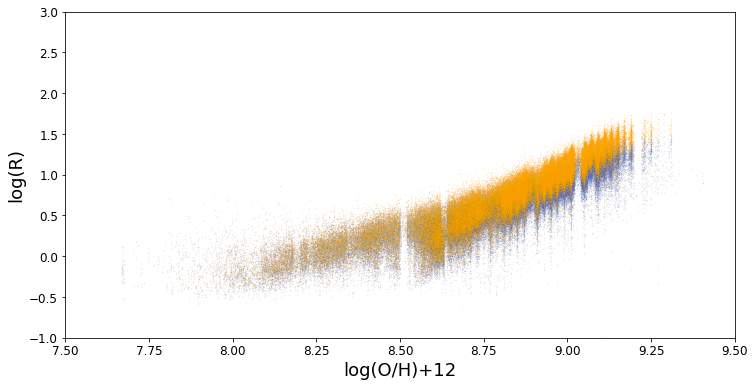

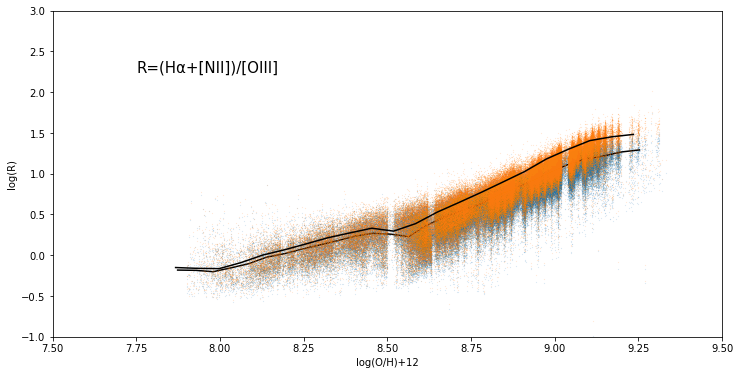

T04 Spearman, uncorrected: 0.9336824319114486
T04 Spearman, corrected: 0.9244552324543982


In [16]:
# Add poly fit
# Add Spearman correl
# Add error bars 

rint = np.log10((Halpha_Batt_int + NII_Batt_int) / OIII_Batt_int)
HaN2_O3_cor = rint
runc = np.log10((Halpha_Batt + NII_Batt) / OIII_Batt)
HaN2_O3_unc = runc

# metallicity, from SDSS
logOH_p50_Batt = BattistiSpecProp['logOH_p50']
tre_sdss = logOH_p50_Batt

# Log(r) error propagation 

plt.figure(figsize=(12, 6))
plt.scatter(logOH_p50_Batt, rint, s=.01, c='royalblue', marker='.')
plt.scatter(logOH_p50_Batt, runc, s=.01, c='orange', marker='.')
plt.xlim([8,9.5])
#plt.ylim([0,10])
plt.xlabel("log(O/H)+12",size=18)
plt.ylabel("log(R)",size=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(-1,3)
plt.xlim(7.5,9.5)
#plt.text(8.2,6,"Ha+NII / OIII",size=22)
plt.show()


### Tremonti 2004 from SDSS
# corrected 
plt.figure(figsize=(12,6))
w = np.where((tre_sdss <9.35) &(tre_sdss > 7.9) & (HaN2_O3_cor > -5)& (HaN2_O3_cor < 5)&(np.isnan(HaN2_O3_cor) ==False))[0] 
HaN2_O3_cor1 = HaN2_O3_cor[w]
tre_sdsscor = tre_sdss[w]
plt.plot(tre_sdsscor, HaN2_O3_cor1, '.', markersize = .11)
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.05
total_bins = int((max(tre_sdsscor) - min(tre_sdsscor)) / binwidth)
bins = np.linspace(min(tre_sdsscor), max(tre_sdsscor), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdsscor, bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_cor1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_cor1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_cor1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_cor1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.5)
#plt.plot(x, perc1, 'k--', linewidth=1.2)
#plt.plot(x, perc2, 'k--', linewidth=1.2)
# uncorrected
w = np.where((tre_sdss <9.35) &(tre_sdss > 7.9) & (HaN2_O3_unc > -5)& (HaN2_O3_unc < 5))[0] 
plt.plot(tre_sdss[w], HaN2_O3_unc[w], '.', markersize = 0.11)
HaN2_O3_unc1 = HaN2_O3_unc[w]
tre_sdssunc = tre_sdss[w]
#O3_HaN2_unc = O3_HaN2_Batt[w]
binwidth = 0.06
total_bins = int((max(tre_sdss[w]) - min(tre_sdss[w])) / binwidth)
bins = np.linspace(min(tre_sdss[w]), max(tre_sdss[w]), total_bins)
delta = bins[1]-bins[0]
idx = np.digitize(tre_sdss[w], bins)
#print(max(O3_HaN2_cor[idx==8]), idx)
median = [np.percentile(HaN2_O3_unc1[idx==k+1], 50) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc1 = [np.percentile(HaN2_O3_unc1[idx==k+1], 16) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
perc2 = [np.percentile(HaN2_O3_unc1[idx==k+1], 84) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
x = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_unc1[idx==k+1]) > 4]
plt.plot(x, median, 'k-', linewidth=1.5)
#plt.plot(x, perc1, 'k--', linewidth=1.2)
#plt.plot(x, perc2, 'k--', linewidth=1.2)

plt.text(7.75,2.25,'R=(H\u03B1+[NII])/[OIII]',fontsize=15)
plt.xlabel('log(O/H)+12')
plt.ylabel('log(R)')
plt.ylim(-1,3)
plt.xlim(7.5,9.5)
#plt.savefig("HbHaN2_O3.dustcomp.7.22.pdf",format="pdf")
plt.show()

## Spearman correlation
HaN2_O3_unc_spearman, p_value = stats.spearmanr(tre_sdssunc, HaN2_O3_unc1)
print('T04 Spearman, uncorrected:',HaN2_O3_unc_spearman)
## This one is not working. I'm wondering if it's because tre_sdss comes directly from the data frame, while Batt_int does as well
# but it has a calculation on it. How do I make them "talk" again?
HaN2_O3_cor_spearman, p_value = stats.spearmanr(tre_sdsscor, HaN2_O3_cor1)
print('T04 Spearman, corrected:',HaN2_O3_cor_spearman)



# EBV Grid

E(B-V) =  0.0 [ -0.40975735  10.94710249 -95.90214636 276.30780019]
E(B-V) =  0.1 [ -0.40980203  10.94816805 -95.91067161 276.29005401]
E(B-V) =  0.2 [ -0.40980383  10.94816491 -95.91034196 276.24791039]
E(B-V) =  0.30000000000000004 [ -0.40986628  10.94964895 -95.9221234  276.238536  ]
E(B-V) =  0.4 [ -0.40994202  10.95149729 -95.93720927 276.23906864]


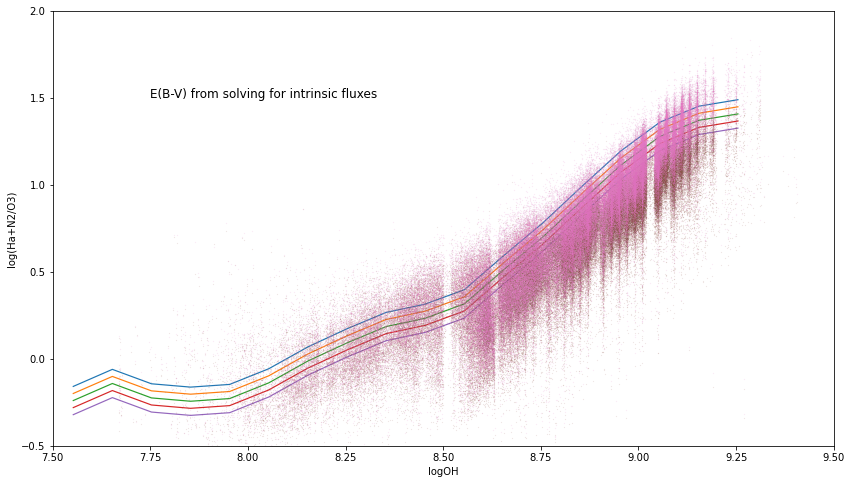

E(B-V) =  0.0 [-8.11916944e-01  3.36624706e+01 -5.57792187e+02  4.61811737e+03
 -1.91059219e+04  3.16007911e+04]
E(B-V) =  0.1 [-8.11415684e-01  3.36415174e+01 -5.57442301e+02  4.61519994e+03
 -1.90937750e+04  3.15806285e+04]
E(B-V) =  0.2 [-8.11976555e-01  3.36650072e+01 -5.57835268e+02  4.61848251e+03
 -1.91074669e+04  3.16034830e+04]
E(B-V) =  0.30000000000000004 [-8.11621931e-01  3.36503154e+01 -5.57592143e+02  4.61647371e+03
 -1.90991798e+04  3.15898682e+04]
E(B-V) =  0.4 [-8.11683917e-01  3.36528658e+01 -5.57634087e+02  4.61681843e+03
 -1.91005959e+04  3.15922351e+04]


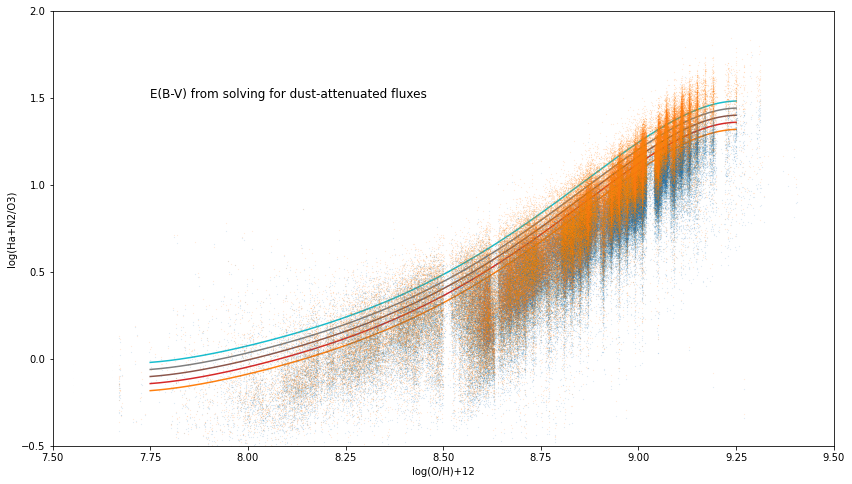

In [23]:
# Try surface fitting

# Create grid of E(B-V)
# need to iterate every value of EB_Vgrid over every value of uncorrected halpha_batt
EB_Vgrid = np.arange(-0.5,0.5,0.1)

# Theoretical, solve for dust-corrected
# Makes dusty = 0, want the opposite, intrinsic = 0
Halpha_Batt_ebv = np.outer((pow(10,0.4*k_Ha*EB_Vgrid)), Halpha_Batt)
OIII5007_Batt_ebv = np.outer((pow(10,0.4*k_OIII5007*EB_Vgrid)),OIII5007_Batt)
OIII4959Batt_ebv = np.outer((pow(10,0.4*k_OIII4959*EB_Vgrid)),OIII4959_Batt)
OIII_Batt_ebv = OIII5007_Batt_ebv + OIII4959Batt_ebv
NII84_Batt_ebv = np.outer((pow(10,0.4*k_NII84*EB_Vgrid)),NII84_Batt)
NII48_Batt_ebv = np.outer((pow(10,0.4*k_NII48*EB_Vgrid)),NII48_Batt)
NII_Batt_ebv = NII84_Batt_ebv + NII48_Batt_ebv
HaN2_O3ebv = (Halpha_Batt_ebv + NII_Batt_ebv)/OIII_Batt_ebv

# Theoretical, solve for dusty
# Fatt = Fint / (10^xyz)
Halpha_Batt_unc_ebv = np.outer(Halpha_Batt_int,(1/(pow(10,0.4*k_Ha*EB_Vgrid))))
OIII5007_Batt_unc_ebv = np.outer(OIII5007_Batt_int,(1/(pow(10,0.4*k_OIII5007*EB_Vgrid))))
OIII4959Batt_unc_ebv = np.outer(OIII4959_Batt_int,(1/(pow(10,0.4*k_OIII4959*EB_Vgrid))))
OIII_Batt_unc_ebv = OIII5007_Batt_unc_ebv + OIII4959Batt_unc_ebv
NII84_Batt_unc_ebv = np.outer(NII84_Batt_int,(1/(pow(10,0.4*k_NII84*EB_Vgrid))))
NII48_Batt_unc_ebv = np.outer(NII48_Batt_int,(1/(pow(10,0.4*k_NII48*EB_Vgrid))))
NII_Batt_unc_ebv = NII84_Batt_unc_ebv + NII48_Batt_unc_ebv
HaN2_O3_unc_ebv = (Halpha_Batt_unc_ebv + NII_Batt_unc_ebv)/OIII_Batt_unc_ebv

# Poly fitting of corrected and uncorrected trend
# x = np.arange(7.75,9.25,0.1)
# coeff_cor = (-2.06623496e+00)*(x**5) +  8.73801056e+01*x**4  -1.47681373e+03*x**3 +  1.24691001e+04*x**2 -5.25944980e+04*x +  8.86603232e+04
# coeff_unc = (-3.14986801e+00)*(x**5) + 1.32590720e+02*(x**4) -2.23068346e+03*(x**3) + 1.87496186e+04*(x**2) -7.87382864e+04*x + 1.32163854e+05


EB_Vgrid = np.arange(0,0.5,0.1)
#print(EB_Vgrid[4])
plt.figure(figsize=(14,8))
for i in range(len(EB_Vgrid)):
    # calculate theoretical intrinsic fluxes for each EBV value, from uncorrected fluxes
    Halpha_Batt_ebv = (pow(10,0.4*k_Ha*EB_Vgrid[i]))*Halpha_Batt
    OIII5007_Batt_ebv = (pow(10,0.4*k_OIII5007*EB_Vgrid[i]))*OIII5007_Batt
    OIII4959Batt_ebv = (pow(10,0.4*k_OIII4959*EB_Vgrid[i]))*OIII4959_Batt
    OIII_Batt_ebv = OIII5007_Batt_ebv + OIII4959Batt_ebv
    NII84_Batt_ebv = (pow(10,0.4*k_NII84*EB_Vgrid[i]))*NII84_Batt
    NII48_Batt_ebv = (pow(10,0.4*k_NII48*EB_Vgrid[i]))*NII48_Batt
    NII_Batt_ebv = NII84_Batt_ebv + NII48_Batt_ebv
    # calculate ratio
    HaN2_O3ebv = np.log10((Halpha_Batt_ebv + NII_Batt_ebv)/OIII_Batt_ebv)
    #plt.plot(tre_sdss, HaN2_O3ebv, '.',markersize=.1)
    # median calculation
    binwidth = 0.1
    total_bins = int((max(tre_sdss) - min(tre_sdss)) / binwidth)
    bins = np.linspace(min(tre_sdss), max(tre_sdss), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(tre_sdss, bins)
    #print(max(O3_HaN2_cor[idx==8]), idx)
    median = [np.percentile(HaN2_O3ebv[idx==k+1], 50) for k in range(total_bins) 
              if len(HaN2_O3ebv[idx==k+1]) > 4]
    perc1 = [np.percentile(HaN2_O3ebv[idx==k+1], 16) for k in range(total_bins) 
             if len(HaN2_O3ebv[idx==k+1]) > 4]
    perc2 = [np.percentile(HaN2_O3ebv[idx==k+1], 84) for k in range(total_bins) 
             if len(HaN2_O3ebv[idx==k+1]) > 4]
    xm = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3ebv[idx==k+1]) > 4]
    # plotting the theoretical EBV lines
    plt.plot(xm, median, linewidth=1.2, label=[i])
    polyfit = np.polyfit(xm, median, 3)
    print("E(B-V) = ",EB_Vgrid[i],polyfit)
    p1 = np.poly1d(polyfit)
    t1 = np.linspace(7.75, 9.25, 5000)
    #plt.plot(xm, median, '.',t1, p1(t1), '-', markersize=.01)
    #plt.plot(x, perc1, 'k--', linewidth=1.2)
    #plt.plot(x, perc2, 'k--', linewidth=1.2)
    #plt.legend()
# plotting the SDSS trends
#plt.plot(tre_sdss, HaN2_O3_Batt_int, '.',markersize=.1,label='corrected')
#plt.plot(tre_sdss, HaN2_O3_Batt, '.',markersize=.1,label='uncorrected')
plt.plot(tre_sdss, rint, '.',markersize=.1,label='corrected')
plt.plot(tre_sdss, runc, '.',markersize=.1,label='uncorrected')
# plotting the poly fitting 
#plt.plot(x,coeff_cor,'k',linewidth=1.2)#,'-')
#plt.plot(x,coeff_unc,'k',linewidth=1.2)#,'-')
#plt.legend(handles=[lab1,lab2],loc='lower right')
plt.xlim(7.5,9.5)
plt.ylim(-0.5,2)
plt.text(7.75,1.5,"E(B-V) from solving for intrinsic fluxes",fontsize=12)
plt.xlabel('logOH')
plt.ylabel('log(Ha+N2/O3)')
plt.show()



### Solve for attenuated fluxes instead
EB_Vgrid = np.arange(0,0.5,0.1)
plt.figure(figsize=(14,8))
for i in range(len(EB_Vgrid)):
    # calculate theoretical attenuated fluxes for each EBV value, from corrected fluxes
    Halpha_Batt_unc_ebv = Halpha_Batt_int/(pow(10,0.4*k_Ha*EB_Vgrid[i]))
    #print(Halpha_Batt_unc_ebv)
    OIII5007_Batt_unc_ebv = OIII5007_Batt_int/(pow(10,0.4*k_OIII5007*EB_Vgrid[i]))
    OIII4959_Batt_unc_ebv = OIII4959_Batt_int/(pow(10,0.4*k_OIII4959*EB_Vgrid[i]))
    OIII_Batt_unc_ebv = OIII5007_Batt_unc_ebv + OIII4959_Batt_unc_ebv
    NII84_Batt_unc_ebv = NII84_Batt_int/(pow(10,0.4*k_NII84*EB_Vgrid[i]))
    NII48_Batt_unc_ebv = NII48_Batt_int/(pow(10,0.4*k_NII48*EB_Vgrid[i]))
    NII_Batt_unc_ebv = NII84_Batt_unc_ebv + NII48_Batt_unc_ebv
    w = np.where((OIII_Batt_unc_ebv > 0)&(NII_Batt_unc_ebv >0 ) & (Halpha_Batt_unc_ebv>0))[0]
    HaN2_O3_unc_ebv = np.log10((Halpha_Batt_unc_ebv[w] + NII_Batt_unc_ebv[w])/OIII_Batt_unc_ebv[w])
    tre_sdss1 = tre_sdss[w]
    #HaN2_O3_unc_ebv = np.where(HaN2_O3_unc_ebv > 0)
    #print(HaN2_O3_unc_ebv)
    #plt.plot(tre_sdss, HaN2_O3_unc_ebv, '.',markersize=.1)
    # median calculation
    binwidth = 0.1
    total_bins = int((max(tre_sdss1) - min(tre_sdss1)) / binwidth)
    bins = np.linspace(min(tre_sdss1), max(tre_sdss1), total_bins)
    delta = bins[1]-bins[0]
    idx = np.digitize(tre_sdss1, bins)
    #print(max(O3_HaN2_cor[idx==8]), idx)
    median = [np.percentile(HaN2_O3_unc_ebv[idx==k+1], 50) 
              for k in range(total_bins) if len(HaN2_O3_unc_ebv[idx==k+1]) > 4]
    #perc1 = [np.percentile(HaN2_O3_unc_ebv[idx==k+1], 16) 
             #for k in range(total_bins) if len(HaN2_O3_unc_ebv[idx==k+1]) > 4]
    #perc2 = [np.percentile(HaN2_O3_unc_ebv[idx==k+1], 84) 
             #for k in range(total_bins) if len(HaN2_O3_unc_ebv[idx==k+1]) > 4]
    xm = [(bins[k]-delta/2) for k in range(total_bins) if len(HaN2_O3_unc_ebv[idx==k+1]) > 4]
    # plotting the theoretical EBV lines
    #plt.plot(xm, median, linewidth=1.2, label=[i])
    #plt.plot(x, perc1, 'k--', linewidth=1.2)
    #plt.plot(x, perc2, 'k--', linewidth=1.2)
    polyfit = np.polyfit(xm, median, 5)
    print("E(B-V) = ",EB_Vgrid[i],polyfit)
    p1 = np.poly1d(polyfit)
    t1 = np.linspace(7.75, 9.25, 5000)
    plt.plot(xm, median, '.',t1, p1(t1), '-', markersize=.01)
    #plt.legend()
# plotting the SDSS trends
plt.plot(tre_sdss, rint, '.',markersize=.1,label='corrected')
plt.plot(tre_sdss, runc, '.',markersize=.1,label='uncorrected')
# plotting the poly fitting 
#plt.plot(x,coeff_cor,'k',linewidth=1.2)#,'-')
#plt.plot(x,coeff_unc,'k',linewidth=1.2)#,'-')
#plt.legend(handles=[lab1,lab2],loc='lower right')
plt.xlim(7.5,9.5)
plt.ylim(-0.5,2)
plt.text(7.75,1.5,"E(B-V) from solving for dust-attenuated fluxes",fontsize=12)
plt.xlabel('log(O/H)+12')
plt.ylabel('log(Ha+N2/O3)')
plt.show()

